In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [2]:
sample_freq = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
sig = wm.get_soft(f_center=0.e5, dB=signal_strength)
sig += wm.get_soft(f_center=-0.e5, dB=signal_strength)
# sig += wm.get_soft(f_center=-1e5, dB=signal_strength)
# sig += wm.get_soft(f_center=2e5, dB=signal_strength)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(dB=noise_strength)

assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power:    %6.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:     %6.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:             %6.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num Samples:     %9d ' % (num_samples))

# Note, that Parseval's theorem holds
from scipy import fft
print("Freqency Energy %6.2f" % (np.sum(np.abs(fft.fft(both))**2)/sample_freq))
print("Time Energy     %6.2f" % (np.sum(np.abs(both)**2)))

Signal power:      6.02 dB
Noise power:       0.00 dB
SNR:               6.02 dB
Num Samples:       1000000 
Freqency Energy 5001133.27
Time Energy     5001133.27


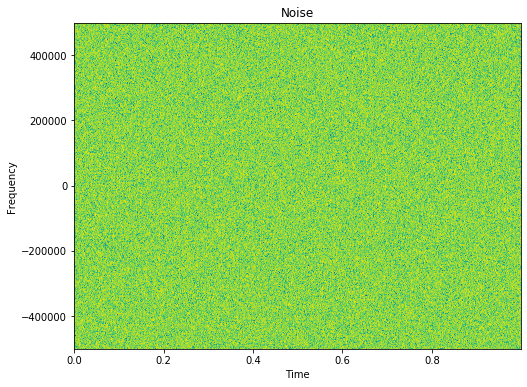

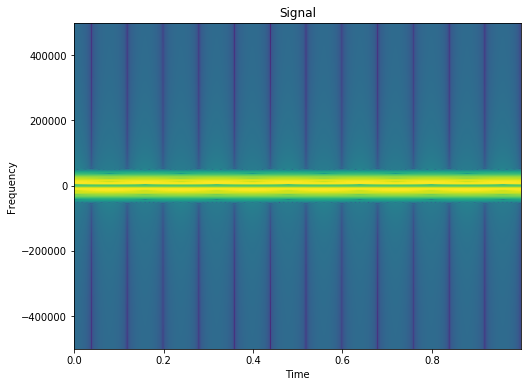

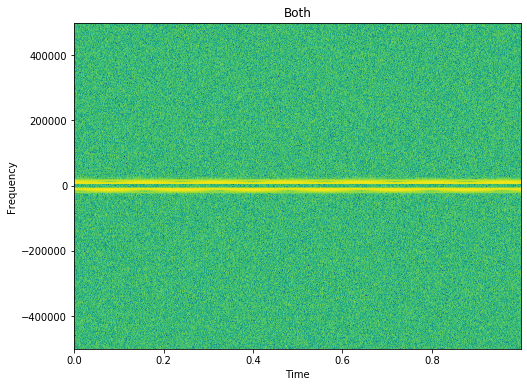

In [3]:
# Plot the resulting signals using our stft
nfft = 1024

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(noise, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [4]:
# Plot only 2nd (x[:, 1]) FFT bin 

class Stft:
    def __init__(self, n=1024, window='flattop'):
        assert ss.util.is_power2(n), 'Only power of 2 stft allowed'
        self.n = n
        self.win = signal.get_window(window, self.n)

    def fft(self, sig, f_sample):
        '''Compute fft and spectrum shifted to natural order.'''
        assert len(sig) == self.n
        dt = 1. / f_sample
        f = fft.fftshift(fft.fftfreq(self.n, dt))
        s = fft.fftshift(fft.fft(sig))
        return f, s

    def window(self, sig):
        '''Apply the window function.'''
        return sig * self.win

    def psd(self, s, f_sample, normalized=True):
        '''Compute the power spectral density.'''
        ps = np.abs(s)**2. / (self.win**2.).sum()
        if normalized:
            ps /= f_sample
        return ps

    def stft(self, sig, f_sample, normalized=True, dB=True):
        '''Compute the stft on a single segment.'''
        assert len(sig) == self.n, 'Signal segment and fft bin length dont match.'
        f, s = self.fft(self.window(sig), f_sample)
        ps = self.psd(s, f_sample, normalized)
        if dB:
            ps = 10. * np.log10(ps)  # signalpower in dB
        return f, ps

    def spectogram(self, sig, f_sample, normalized=True, dB=True):
        '''Compute spectogram by applying stft on every segment.'''
        tl = []
        xl = []
        segs = filter(lambda x: len(x) == self.n,
                      [sig[i:i + self.n] for i in range(0, len(sig), self.n)])
        for i, seg in enumerate(segs):
            f, x = self.stft(seg, f_sample, normalized, dB)
            tl.append(i * self.n * 1. / f_sample)
            xl.append(x)
        xl = np.swapaxes(xl, 0, 1)
        return f, np.array(tl), xl

# sft = ss.Stft(n=1024, window='flattop')
# f, t, x = sft.spectogram(noise, sample_freq, normalized=True, dB=True)

# plt.figure(figsize=(8, 6))
# plt.plot(f, x[:, 1])
# plt.show()

wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=0.01)
sig = wm.get_soft(f_center=1.0e5, dB=signal_strength)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=0.01)
print(len(wgn.get_signal(dB=noise_strength)))

rel = []

for i in range(1000):
    noise = wgn.get_signal(dB=noise_strength)
    sig = wm.get_soft(f_center=1.0e5, dB=signal_strength)
    
    both = sig + noise
#     both = sig
#     both = noise
    
    sft = Stft(n=1024, window='box')
    f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)
    e_box = np.sum(x[768:, 1])
    
    
    sft = Stft(n=1024, window='flattop')
    f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)
    e_flat = np.sum(x[768:, 1])
    
#     e_time = np.sum(np.abs(both[1000:1512])**2)
    
    rel_tmp = e_box / e_flat
    rel.append(rel_tmp)
    
    print(i, rel_tmp)


print(np.sum(rel) / 1000)

# sft = ss.Stft(n=1024, window='flattop')
# f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

# plt.figure(figsize=(8, 6))
# plt.plot(f, x[:, 1])
# plt.show()

10000
0 1.000191734896584
1 0.9336440445326188
2 0.841585541461031
3 1.1139127296694662
4 0.8438123030022326
5 1.1192660445020484
6 0.990767707420769
7 1.210536798382663
8 1.076771698787637
9 0.8422595161702365
10 1.1662343029880051
11 0.961654805535
12 0.9581000573141073
13 1.009847703417068
14 1.0448460175876835
15 0.9422019335417624
16 0.9612610128706485
17 0.8737017173372077
18 1.0893076058872806
19 0.8221064229888568
20 1.1770997289042262
21 0.91832489281729
22 1.0325378440301447
23 1.0499782317215105
24 0.9034619155366838
25 1.0313851353864343
26 0.9590234236331578
27 1.044277702235746
28 0.8983107496540487
29 0.9594016260975018
30 1.1062397179039392
31 1.0694274915239073
32 0.927845460385384
33 1.1024689812435629
34 1.0757599376434306
35 1.0966079921143446
36 0.9236107482946614
37 1.0728281193128784
38 1.0435551838566512
39 1.3063271085651158
40 0.8852938639055823
41 0.9768640788855284
42 0.9183507469530586
43 0.936716459352189
44 1.271020829636106
45 0.9040495010286539
46 0.893

404 1.1177186510843093
405 0.975541768828718
406 0.7699683593491348
407 0.9294412427382033
408 1.2409188533681228
409 1.1381400277874596
410 1.2305045220266966
411 0.901949389375348
412 1.1089185596091258
413 1.0581243775277243
414 1.1241074491510006
415 0.9309841523037541
416 0.9755566658804931
417 1.0408935497754246
418 1.180474575808545
419 1.0278976600348781
420 0.7889171221341114
421 0.8865872952004311
422 1.073665850084969
423 0.9936168441106616
424 0.9484914448337871
425 1.0497929210549075
426 1.2285891467047603
427 1.2077060724674267
428 1.1235157401201314
429 1.0287577233752685
430 1.0245467981744973
431 1.0891745102318555
432 0.973124653757021
433 1.0038063859375628
434 1.1135354692507025
435 1.0902765989463898
436 0.950985272107457
437 0.9583729260137875
438 1.1045813294926528
439 1.1700046887774151
440 0.9906079496229299
441 0.9006204432985535
442 0.9428541212379841
443 1.06216258351002
444 1.0916500735491117
445 1.1052427521762145
446 1.2649071291323357
447 1.1003018668978

793 1.0838643429606416
794 0.9380670906428237
795 1.26538374432817
796 0.9779229655762262
797 1.1837632447121305
798 1.092066100673438
799 1.0643297539801322
800 0.7778198653767779
801 1.04199632736791
802 1.026195332317977
803 1.1551935642602296
804 1.026286269710785
805 1.0275023343362328
806 0.9290701793205679
807 1.1057310719893452
808 0.8713700435316634
809 1.065192528560597
810 1.2350203155345736
811 1.129703025997959
812 0.9008883457190855
813 0.9723553405963927
814 0.960683008992957
815 1.1106613378260324
816 1.1009738498460484
817 1.0163454889905013
818 1.0486172836273007
819 0.8433089148721874
820 0.9253179949000638
821 1.2115135235038703
822 0.897820741288175
823 0.9928223037798048
824 1.0145965521549531
825 0.9890984309924271
826 1.0581276217580717
827 0.9819267165151014
828 1.0396925240318453
829 0.8768833176948166
830 0.8422971776378302
831 0.9161162221006152
832 0.9621179132370353
833 0.9777772299913452
834 1.0765439956943057
835 0.9508079373675684
836 0.8902450262494274

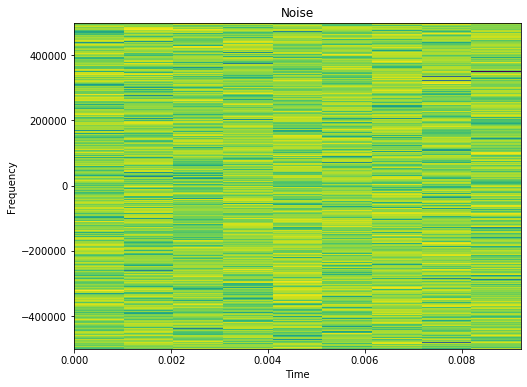

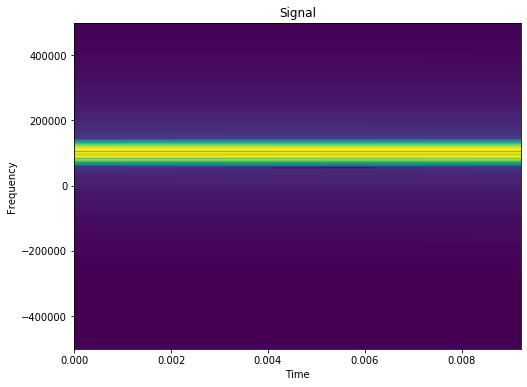

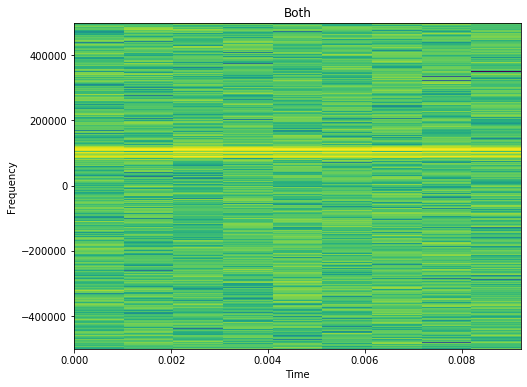

In [5]:
# Plot the resulting signals using matplotlib (in dB)
nfft = 1024

plt.figure(figsize=(8, 6))
plt.specgram(noise,
             NFFT=nfft,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('flattop', nfft))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(sig,
             NFFT=nfft,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('flattop', nfft))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(both,
             NFFT=nfft,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('flattop', nfft))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

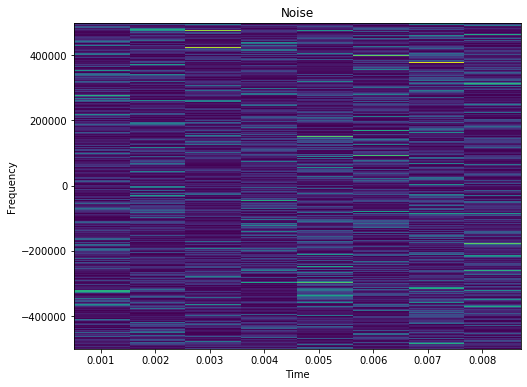

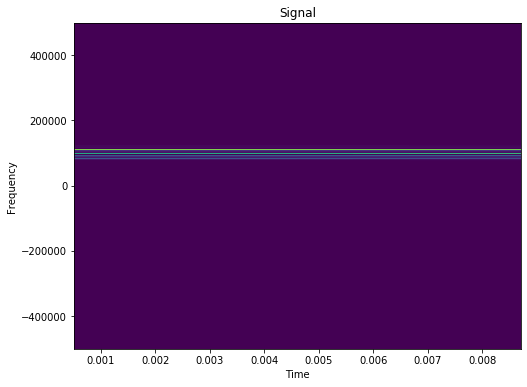

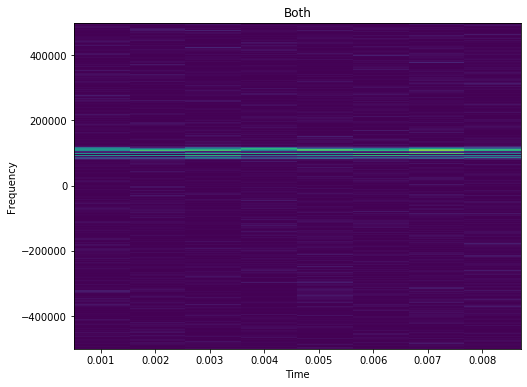

In [6]:
# Plot the resulting signals using the scipy spectogram (linear, not dB )
from scipy import fft
nfft = 1024

plt.figure(figsize=(8, 6))
f, t, x = signal.spectrogram(noise,
                             sample_freq,
                             return_onesided=False,
                             window='flattop',
                             nperseg=nfft,
                             nfft=nfft,
                             noverlap=0,
                             detrend=False,
                             scaling='density',
                             mode='psd')
plt.pcolormesh(t, fft.fftshift(f), fft.fftshift(x, axes=0), shading='virdis')
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
f, t, x = signal.spectrogram(sig,
                             sample_freq,
                             return_onesided=False,
                             window='box',
                             nperseg=nfft,
                             nfft=nfft,
                             noverlap=0,
                             detrend=False,
                             scaling='density',
                             mode='psd')
plt.pcolormesh(t, fft.fftshift(f), fft.fftshift(x, axes=0), shading='virdis')
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 6))
f, t, x = signal.spectrogram(both,
                             sample_freq,
                             return_onesided=False,
                             window='flattop',
                             nperseg=nfft,
                             nfft=nfft,
                             noverlap=0,
                             detrend=False,
                             scaling='density',
                             mode='psd')
plt.pcolormesh(t, fft.fftshift(f), fft.fftshift(x, axes=0), shading='virdis')
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()